# 🚨 Cybersecurity Anomaly Detection Workflow

This notebook outlines a comprehensive workflow for detecting suspicious activities within logs using advanced machine learning techniques applied to the BETH dataset.

The dataset, as discussed in the article [<<article_name>>], serves as the foundation for preprocessing and performance comparison.

## 📚 Libraries

- Utilizing essential data science, machine learning, and natural language processing packages for a robust analysis.
- Downloading the punkt tokenization module to enhance natural language processing capabilities.


In [24]:
import ast
import re
from pathlib import Path
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import OneClassSVM

In [25]:
from datamodules.beth_datareader import read_data
train_df, val_df, test_df = read_data()


## 👷 Building the Pipeline
#### 🔍 Feature Descrptipons
* **Timestamp:** As suggested by the authors, we aim to consider the dataset as samples and not as a timeseries, so it can be left out.

* **ProcessID & ParentProcessID:** Values are encoded, not numerically meaningful.
    - Values 0, 1, 2 represent OS processes.
    - Other values are random and can be transformed into binary, True/False columns.

* **ThreadID:** This feature is identical to ProcessID unless the process uses multithreading.
    - Binary encoding is suggested, representing whether it is identical to the Process ID or not.

* **UserId:** The system default behavior is to assign system/OS 'users' with a value below 1000 and logged-in users with values 1000 or above. Two ideas:
    - Binary encoding for <1000 and >= 1000.
    - Divide the value by 1000. This way, we retain more information while still distinguishing systems and logged-in users (0 to 1 vs. above 1).

In [26]:
def transform_process_ids(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ProcessID & ParentProcessID into binary columns.
    Values 0, 1, 2 represent OS processes, while others are random values.
    Args:
        data (pd.DataFrame): Input dataframe with 'ProcessID' and
        'ParentProcessID' columns.

    Returns:
        pd.DataFrame: Transformed Dataframe with 'IsOSProcess' and
        'IsOSParentProcess' binary columns.
    """

    data["isOSProcess"] = np.where(data["processId"].isin([0, 1, 2]), 1.0, 0.0)
    data["isOSParentProcess"] = np.where(
        data["parentProcessId"].isin([0, 1, 2]), True, False
    )
    return data


def transform_thread_id(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ThreadID into a binary column.
    ThreadID is identical to ProcessID unless the process uses multithreading.
    Args:
        data (pd.DataFrame): Input dataframe with 'ThreadID' and 'ProcessID'
        columns.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsIdenticalThreadID' binary
        column.
    """
    data["isIdenticalThreadId"] = np.where(
        data["threadId"] == data["processId"], True, False
    )
    return data


def transform_user_id(data: pd.DataFrame) -> pd.DataFrame:
    """
    Binary encode UserId based on the suggested criteria.
    UserId below 1000 represents system/os users, and 1000 or above represents
    logged-in users.
    Args:
        data (pd.DataFrame): Input dataframe with 'UserId' column.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsSystemUser' and
        'IsLoggedInUser' binary columns.
    """
    data["isLoggedInUser"] = data["userId"] >= 1000
    data["transformedUserId"] = data["userId"] / 1000
    return data


def transform_mount_namespace(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transform MountNamespace into a binary column.
    Args:
        data (pd.DataFrame): Input dataframe with 'MountNamespace' column.

    Returns:
        pd.DataFrame: Transformed dataframe with 'IsMountNamespace' binary
        column.
    """
    data["mountedMntDir"] = data["mountNamespace"] == 4026531840
    return data

"Log transform" 🙃

In [27]:
numerical_column_transforms = [
    (
        "process_ids",
        FunctionTransformer(transform_process_ids, validate=False),
    ),
    (
        "thread_id",
        FunctionTransformer(transform_thread_id, validate=False),
    ),
    (
        "user_id",
        FunctionTransformer(transform_user_id, validate=False),
    ),
    (
        "mount_space",
        FunctionTransformer(transform_mount_namespace, validate=False),
    ),
]

### Non-numerical Features

In [28]:
def list_length_transformer(data: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a new column with the length of the stackAddresses.
    Args:
        data (pd.DataFrame): The data to transform.
    Returns:
        pd.DataFrame: The transformed data.
    """
    data["list_length"] = data["stackAddresses"].apply(len)
    return data

In [29]:
categorical_column_transforms = [
    (
        "list_length",
        FunctionTransformer(list_length_transformer, validate=False),
    ),
]

In [30]:
class ArgsEmbeddingTransformer(BaseEstimator, TransformerMixin):
    """
    This transformer class takes an "args" column and transforms it into an
    embedded sentence vector column of those argtuments.
    The training (fit) step trains a word2vec model on those args, and the
    transform step uses the trained model to embed the args.
    """

    def preprocess_args_string(self, args_string: str) -> list[str]:
        """
        Preprocess the arguments string to tokenize it into words.
        1. Extracts the argument values, removing data types
        2. Clears characters added by the encoding (these are not part of the
        args).
        Args:
            args_string (str): The arguments string to preprocess.

        Returns:
            list: A list of words from the arguments string.
        """
        args_string = str(
            {
                arg["name"]: arg["value"]
                for arg in ast.literal_eval(args_string)
            }
        )
        cleaned_args = re.sub(r"[\[\]{}':,]", "", args_string).lstrip()
        return word_tokenize(cleaned_args)

    def train_word2vec_model(self, X):
        """
        Train a word2vec model on the arguments strings.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.

        Returns:
            Word2Vec: The trained word2vec model.
        """
        word2vec_model = Word2Vec(
            sentences=X["tokenizedArgs"],
            vector_size=30,
            window=5,
            min_count=1,
            workers=6,
            seed=1337,
        )
        self.word2vec_model = word2vec_model

    def get_sentence_vector(self, sentence):
        """
        Get the average word2vec vector for a sentence.
        Args:
            sentence (list): The list of words in the sentence.

        Returns:
            numpy.ndarray: The average word2vec vector for the sentence.
        """
        vectors = [
            self.word2vec_model.wv[word]
            for word in sentence
            if word in self.word2vec_model.wv
        ]
        return sum(vectors) / len(vectors) if vectors else None

    def fit(self, X, y=None):
        """
        Fit the ArgsTokenizerTransformer to the training data.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.
            y (None): Not used.

        Returns:
            ArgsTokenizerTransformer: The fitted ArgsTokenizerTransformer.
        """
        X_copy = X.copy()
        X_copy["tokenizedArgs"] = X_copy["args"].apply(
            self.preprocess_args_string
        )
        self.train_word2vec_model(X_copy)
        return self

    def fillna_embeddings(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Fills in the missing embeddings with zeros.
        Args:
            data (pd.DataFrame): The DataFrame to fill in the missing embeddings.
        Returns:
            pd.DataFrame: The DataFrame with filled in missing embeddings.
        """
        data["embedding"] = data["embedding"].apply(
            lambda x: np.zeros(30, dtype=np.float32) if x is None else x
        )
        return data

    def transform(self, X):
        """
        Transform the arguments strings into word2vec vectors.
        Args:
            X (DataFrame): The DataFrame containing the arguments strings.

        Returns:
            DataFrame: The DataFrame with the word2vec vectors added.
        """
        X_copy = X.copy()
        if "tokenizedArgs" not in X_copy.columns:
            X_copy["tokenizedArgs"] = X_copy["args"].apply(
                self.preprocess_args_string
            )
        X_copy["embedding"] = X_copy["tokenizedArgs"].apply(
            self.get_sentence_vector
        )
        X_copy = self.fillna_embeddings(X_copy)
        return X_copy

In [31]:
def embedding_to_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms an embedding column into a dataframe and concatenates it to the
    original dataframe.
    Drops the embedding column.
    Args:
        data (pd.DataFrame): Dataframe with embeddings.

    Returns:
        pd.DataFrame: Dataframe with embeddings concatenated.
    """
    embeddings = np.vstack(data["embedding"])
    embeddings_df = pd.DataFrame(embeddings)
    data = pd.concat([data, embeddings_df], axis=1)
    data.columns = data.columns.astype(str)
    return data.drop(columns=["embedding"])

In [32]:
args_to_embedding_transformer = [
    ("args_tokenizer", ArgsEmbeddingTransformer()),
    (
        "embedding_to_columns",
        FunctionTransformer(embedding_to_columns, validate=False),
    ),
]

In [33]:
columns_to_drop = [
    "processId",
    "parentProcessId",
    "threadId",
    "userId",
    "stackAddresses",
    "mountNamespace",
    "timestamp",
    "processName",
    "eventName",
    "hostName",
    "args",
    "tokenizedArgs",
]


def transform_drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """
    Drop pre-transformation columns and columns that are not needed for
    training.
    Args:
        data (pd.DataFrame): Input dataframe.

    Returns:
        pd.DataFrame: Transformed dataframe with dropped columns.
    """
    data = data.drop(columns=columns_to_drop)
    return data


drop_columns_transformer = [
    (
        "drop_columns",
        FunctionTransformer(transform_drop_columns, validate=False),
    )
]

In [34]:
pipeline = Pipeline(
    numerical_column_transforms
    + categorical_column_transforms
    + args_to_embedding_transformer
    + drop_columns_transformer
)

* Take the embedded column and turn it into a stacked numpy array, concatenate to the df from the right
* Cast all values into np.float32
* Check if we can use sparse matrix
* Separate "sus" & "evil" from X dataframe to a y dataframe
* Run models

## 🏃🏻‍♂️ Running the datasets through the pipeline

In [21]:
train_df, val_df, test_df = read_data()

In [22]:
mlflow.autolog(disable=True)
transformed_train_df = pipeline.fit_transform(train_df)
y_train = transformed_train_df["sus"]
X_train = transformed_train_df.drop(columns=["sus", "evil"])
X_column_names = X_train.columns

transformed_val_df = pipeline.transform(val_df)
y_val = transformed_val_df["sus"]
X_val = transformed_val_df.drop(columns=["sus", "evil"])

transformed_test_df = pipeline.transform(test_df)
y_test = transformed_test_df["sus"]
X_test = transformed_test_df.drop(columns=["sus", "evil"])

In [23]:
output_directory = Path("data/np_arrays")
output_directory.mkdir(parents=True, exist_ok=True)
np.save(output_directory / "X_column_names.npy", np.array(X_column_names))
datasets = [
    ("X_train.npy", X_train),
    ("y_train.npy", y_train),
    ("X_val.npy", X_val),
    ("y_val.npy", y_val),
    ("X_test.npy", X_test),
    ("y_test.npy", y_test),
]

for filename, data in datasets:
    np.save(output_directory / filename, data, allow_pickle=True)

In [35]:
X_train

,eventId,argsNum,returnValue,isOSProcess,isOSParentProcess,isIdenticalThreadId,isLoggedInUser,transformedUserId,mountedMntDir,list_length,...,20,21,22,23,24,25,26,27,28,29
0,157,5,0,0.0,True,False,False,0.100,False,36,...,-0.691947,2.157877,-2.182917,1.066777,0.585601,-1.586007,0.543722,0.030456,1.769720,0.857734
1,3,1,0,0.0,True,False,False,0.100,False,17,...,0.428610,-0.413533,-0.778762,-1.968185,2.447556,-0.073705,-1.158945,-2.068379,1.368733,-0.271107
2,1010,0,0,0.0,True,False,False,0.100,False,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,21,2,-2,0.0,False,True,False,0.000,True,2,...,-0.748657,0.189553,0.729905,1.073920,1.123768,-0.836740,-0.501180,-1.504073,-3.705139,-0.544675
4,1005,4,0,0.0,False,True,False,0.000,True,34,...,0.329148,-1.964248,0.935169,2.892125,-0.602152,-1.411354,-0.149754,0.724962,0.004085,0.772239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763139,1003,1,0,0.0,False,True,False,0.000,True,2,...,-0.633383,-1.756553,1.237484,2.086617,3.134090,-2.123379,-0.657099,0.088652,-0.337171,3.718295
763140,62,2,0,0.0,False,True,False,0.000,True,2,...,-2.040581,-0.910550,-0.148942,1.472319,0.659164,-1.778805,1.573450,-1.777460,-1.255147,0.258230
763141,1010,0,0,0.0,False,True,False,0.000,True,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
763142,1010,0,0,0.0,True,True,False,0.109,True,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
X_train[X_train.columns[-30:]]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.008045,-1.477041,-0.500191,-1.724982,-0.216044,1.929123,0.345819,-0.081760,-1.357898,3.641452,...,-0.691947,2.157877,-2.182917,1.066777,0.585601,-1.586007,0.543722,0.030456,1.769720,0.857734
1,-1.732885,-2.626925,-0.546267,-0.646986,0.265588,1.839006,-0.097250,-1.294796,-0.903962,1.250704,...,0.428610,-0.413533,-0.778762,-1.968185,2.447556,-0.073705,-1.158945,-2.068379,1.368733,-0.271107
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-1.610379,-0.615637,1.945134,-0.868489,-2.260552,0.769048,-1.244057,2.104300,0.822824,-1.692610,...,-0.748657,0.189553,0.729905,1.073920,1.123768,-0.836740,-0.501180,-1.504073,-3.705139,-0.544675
4,0.000812,-0.582554,-2.523441,-1.662414,-0.452048,0.289060,1.607863,-0.956676,1.594412,-1.136930,...,0.329148,-1.964248,0.935169,2.892125,-0.602152,-1.411354,-0.149754,0.724962,0.004085,0.772239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763139,0.833668,0.197370,-0.281124,-1.126614,-0.992291,-0.046914,-1.782167,-1.520976,1.152607,-0.084352,...,-0.633383,-1.756553,1.237484,2.086617,3.134090,-2.123379,-0.657099,0.088652,-0.337171,3.718295
763140,0.739007,-1.329746,-0.254001,-0.848837,-1.544169,2.544709,-3.127887,1.339501,-3.953002,5.075535,...,-2.040581,-0.910550,-0.148942,1.472319,0.659164,-1.778805,1.573450,-1.777460,-1.255147,0.258230
763141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
763142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train[X_train.columns[-30:]])
pca_df = pd.DataFrame(
    data={
        "PCA1": pca_result[:, 0],
        "PCA2": pca_result[:, 1],
        "sus": X_train["sus"],
    }
)
sns.scatterplot(
    x="PCA1", y="PCA2", hue="sus", data=pca_df, palette={1: "red", 0: "blue"}
)

NameError: name 'StandardScaler' is not defined

<Axes: xlabel='PCA1', ylabel='PCA2'>

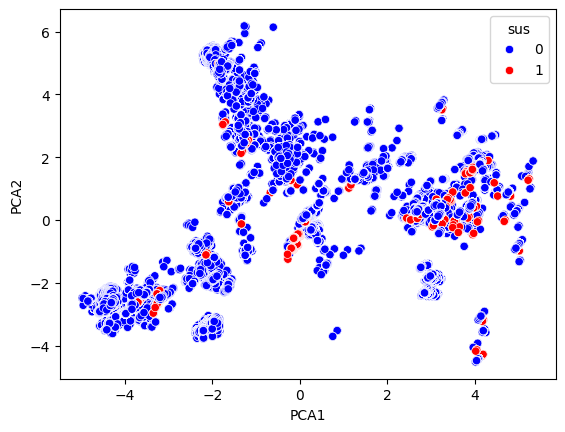

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import pandas as pd
import seaborn as sns

X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_train_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data={
        "PCA1": pca_result[:, 0],
        "PCA2": pca_result[:, 1],
        "sus": y_train,
    }
)

# Plot the scatterplot
sns.scatterplot(
    x="PCA1", y="PCA2", hue="sus", data=pca_df, palette={1: "red", 0: "blue"}
)

<Axes: xlabel='PCA1', ylabel='PCA2'>

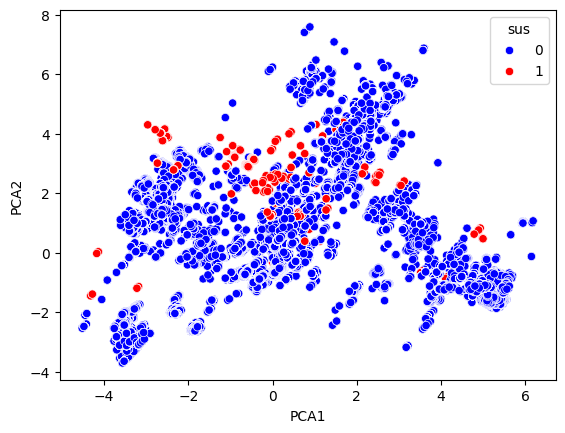

In [46]:
pca_df = pd.DataFrame(
    data={
        "PCA1": pca_result[:, 1],
        "PCA2": pca_result[:, 2],
        "sus": y_train,
    }
)

# Plot the scatterplot
sns.scatterplot(
    x="PCA1", y="PCA2", hue="sus", data=pca_df, palette={1: "red", 0: "blue"}
)